In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy.linalg import det
%matplotlib inline

# Динамическая выпуклая оболочка

Мы хотим построить структуру данных которая могла бы поддерживать выпуклую оболочку для множества точек, 
а так же обрабатывать запросы вставки, удаления и локализации точки и слияния двух оболочек.

Для начала, определим двумерные точки и операции их лексикографического сравнения.
Считаем, что $p < q$, если $p_y < q_y \vee p_y = q_y \wedge p_x < q_x$

In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __str__(self):
        return '({0}, {1})'.format(self.x, self.y)
    def __lt__(self, other):
        return self.y < other.y or self.y == other.y and self.x <  other.x
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    def __le__(self, other):
        return self < other or self == other
    def __gt__(self, other):
        return other < self
    def __ge__(self, other):
        return other < self or self == other
    def __ne__(self, other):
        return not self == other

Пример работы:

In [3]:
p1 = Point(0, 0)
p2 = Point(1, 0)
p3 = Point(1, 1)
print('{0} < {1}: {2}'.format(str(p1), str(p2), p1 < p2))
print('{0} < {1}: {2}'.format(str(p2), str(p3), p2 < p3))
print('{0} < {1}: {2}'.format(str(p1), str(p3), p1 < p3))
print('{0} < {1}: {2}'.format(str(p1), str(p1), p1 < p1))
print('{0} <= {1}: {2}'.format(str(p1), str(p1), p1 <= p1))

(0, 0) < (1, 0): True
(1, 0) < (1, 1): True
(0, 0) < (1, 1): True
(0, 0) < (0, 0): False
(0, 0) <= (0, 0): True


Определим предикат поворота в $2D$:

In [4]:
def rot(a, b, c):
    return np.sign((a.x - c.x) * (b.y - c.y) - (b.x - c.x) * (a.y - c.y))

Мы хотим получить алгоритм, который мог бы поддерживать выпуклую оболочку в онлайне с возможностью добавления, удаления и локализации точки в выпуклой оболочке.
Здесь приведен алгоритм делающий эти три операции за $O(log^2n)$.

Для начала, определим левую и правую выпуклую оболочку множества точек $P$.


## Определение

Левой (Правой) выпуклой оболочкой множества точек $P$ называется выпуклая оболочка множества точек $P\cup \left\{(+\infty, 0)\right\}$ ($P\cup \left\{(-\infty, 0)\right\}$)

Здесь и далее Будем реализовывать левую выпуклую оболочку, в правой все так же с точностью до знака

Для начала, определим структуры данных, в которых у нас все будет храниться (методы добавим в них позже).
Мы будем хранить отсортированные лексикографически точки в листьях сбалансированного бинарного дерева поиска.
Во внутренних вершинах будем хранить вспомогательную информацию: 
во-первых, наименьшую точку в поддереве с корнем в данной вершине; а во-вторых, 
мост между выпуклыми оболочками точек левого и правого поддеревьев данной вершины.

<table style="border-style: hidden; border-collapse: collapse;">
<tr style="border-style: hidden; border-collapse: collapse;">
    <td style="border-style: hidden; border-collapse: collapse;">
        <div><img src="img/bridge.png"><center>Рис 1. мост между выпуклыми оболочками</center></div>
    </td>
    <td style="border-style: hidden; border-collapse: collapse;">
        <div><img src="img/left-right.png"><center>Рис 2. Левая и правая выпуклые оболочки</center></div>
    </td>
</tr>
</table>

Brdge - определяет мост между двумя выпуклыми оболочками:

In [5]:
class Bridge:
    def __init__(self, p, q):
        self.left = p
        self.right = q

Node - вершина нашего дерева:

In [6]:
class Node:
    def __init__(self, point, parent=None, left=None, right=None, bridge=None):
        self.point = point
        self.parent = parent
        self.left = left
        self.right = right
        self.bridge = bridge
    
    def leaf(self):
        return self.left is None and self.right is None

## Объединение выпуклых оболочек

Пусть, мы хотим объединить оболочки $A$ и $C$, но, для начала наложим на них ограничение - должна существовать горизонтальная прямая, которая их разделяет (как на рисунке 1). Мы можем воспользоватся идеями бинарного поиска для нахождения моста. Для этого необходим критерий спуска, по которому мы будем определять подотрезок, до которого нужно сузить задачу, имея точки $p \in A$ и  $q \in C$, определяющие общую касательную к выпуклым оболочкам множеств $A$ и  $C$.

Обозначим $CH(Q)$ - выпуклая оболочка множества $Q$,

$p^+ = \min\limits_{p' \in \left\{CH(A) > p\right\}} p'$, $p^+$ - верхняя грань $p$ из множества $CH(A)$,<br>
$p^- = \max\limits_{p' \in \left\{CH(A) < p\right\}} p'$, $p^-$ - нижняя грань $p$ из множества $CH(A)$,<br>
аналогично определяются $q^+$ и $q^-$.
Так же, определим поворот вектора $\overline{ab}$ с точкой $c$, как функцию $rot(\overline{ab}, c)$.
Теперь, определим отношение между вектором и точкой "справа" - $rot(\overline{ab}, c) > 0$ (точка справа от вектора).

Далее, рассмотрим все возможные случаи расположения этих точек.

1. Точки $p^+, p^-, q^+, q^-$ лежат справа от вектора $\overline{qp}$ - следовательно, отрезок $qp$ - искомый мост.
2. $p^+, p^-, q^+$ - справа, а $q^+$ - слева от $\overline{qp}$. Тогда отбрасываем $CH(A) < p$ и $CH(C) > q$.
3. $p^{+}$, $p^{-}$, $q^{-}$ — справа, $q^{+}$ — слева от $\overline{qp}$. Отбрасываем $CH(A) < p$ и $CH(C) < q$.
4. Как в случае 2, только слева от $\overline{qp}$ находится точка $p^{+}$. Отбрасываем $CH(A) < p$ и $CH(C) > q$.
5. Как в случае 3, только слева от $\overline{qp}$ находится точка $p^{-}$. Отбрасываем $CH(A) > p$ и $CH(C) > q$.
6. $p^{-}$, $q^{+}$ — справа, $p^{+}$, $q^{-}$ — слева от $\overline{qp}$. Отбрасываем $CH(A) < p$ и $CH(C) > q$.
7. $p^{+}$, $q^{+}$ — справа, $p^{-}$, $q^{-}$ — слева от $\overline{qp}$. Отбрасываем $CH(C) > q$.
8. $p^{-}$, $q^{-}$ — справа, $p^{+}$, $q^{+}$ — слева от $\overline{qp}$. Отбрасываем $CH(A) < p$.
9. $p^{+}$, $q^{-}$ — справа, $p^{-}$, $q^{+}$ — слева от $\overline{qp}$. Этот случай дробится на два подслучая.

можно сразу определить функцию, которая различает подслучаи:

In [7]:
def case(p, q, p_plus, p_minus, q_plus, q_minus, m=None, right=1):
    pp = rot(p, q, p_plus)
    pm = rot(p, q, p_minus)
    qp = rot(p, q, q_plus)
    qm = rot(p, q, q_minus)
    left = -right
    if pp == pm == qp == qm == right:
        return 1
    elif pp == pm == qp == right and qm == left:
        return 2
    elif pp == pm == qm == right and qp == left:
        return 3
    elif qp == qm == pm == right and pp == left:
        return 4
    elif qp == qm == pp == right and pm == left:
        return 5
    elif pm == qp == right and pp == qm == left:
        return 6
    elif pp == qp == right and pm == qm == left:
        return 7
    elif pm == qm == right and pp == qp == left:
        return 8
    elif pp == qm == right and pm == qp == left:
        # еще два подслучая
        if m is None:
            return 9
        a_p = p.y - p_minus.y
        b_p = p_minus.x - p.x
        a_q = q.y - q_plus.y
        b_q = q_plus.x - q.x
        side = np.array([
            [a_p, b_p, -a_p * p.x - b_p*p.y],
            [a_q, b_q, -a_q * q.x - b_q*q.y],
            [0, 1, -m]
        ])
        side = np.sign(det(side))
        if side == right:
            return 10
        elif side == left:
            return 11

Вот как можно схематично показать все случаи:

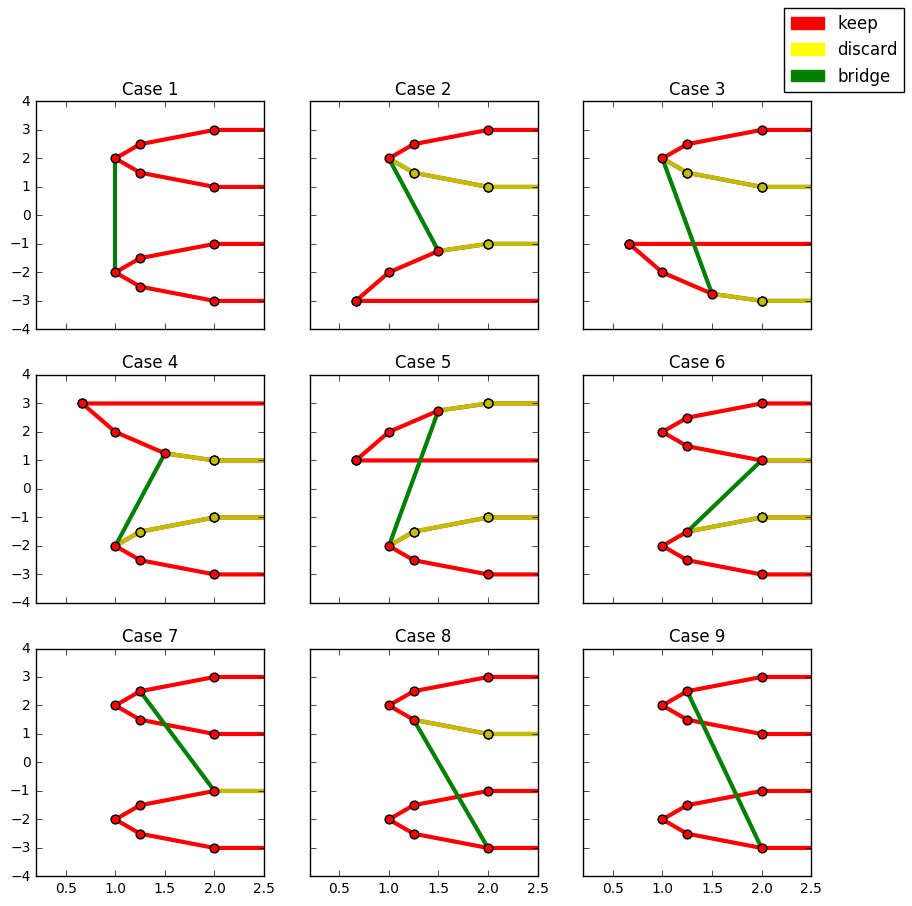

In [8]:
from cases import draw_cases, draw_rest
# функция draw_cases принимает функцию case, которая определяет случай, 
# и называет каждый график по номеру случая
draw_cases(case)

Рассмотрим подслучаи случая 9. Пусть $m$ — прямая, разбивающая $P$ на $A$ и $C$. Пусть также $l_p$ и $l_q$ — касательные к выпуклым оболочкам в точках $p$ и $q$ соответственно. Если $s$ — точка пересечения $l_p$ и $l_q$ лежит ниже прямой $m$, то точка пересечения моста и выпуклой оболочки $A$ может лежать в треугольнике, образованном прямыми $l_p$, $l$ и $m$, или выше $p$. Тогда можем удалить часть $C$ ниже $q$ (см. рис. 10). Случай, когда $s$ лежит выше $m$, аналогичен (см. рис. 11).

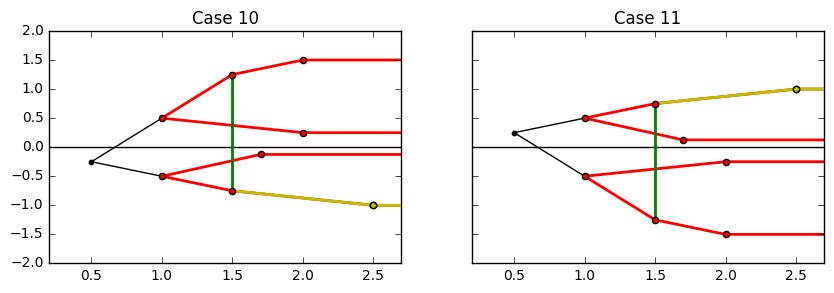

In [9]:
draw_rest(case)

## Получение множества точек

In [10]:
def _get_hull(self, answer, l=float('inf'), r=float('inf')):
    if self.leaf():
        return
    a = self.bridge.left.y
    b = self.bridge.right.y
    if (l < a):
        get_hull(self.left, answer, l, min(a, r))
    if (l <= a and b <= r):
        if (answer.empty()):
            answer = answer.append(self.bridge.left)
        answer = answer.append(self.bridge.right)
    if (b < r):
        get_hull(self.right, answer, max(l, b), r)
def get_hull(self):
    ans = []
    qq = self._get_hull(ans)
    print(qq)
    return qq
setattr(Node, '_get_hull', _get_hull)
setattr(Node, 'get_hull', get_hull)

In [11]:
a = Node(Point(0,0))
a.get_hull()

None


## Локализация

## Вставка

## Удаление

In [12]:
import numpy as np

In [13]:
import bintrees

In [14]:
from bintrees import FastRBTree

In [15]:
tree = FastRBTree()

In [16]:
tree.insert(1, 1)

In [17]:
tree

RBTree({1: 1})

In [18]:
tree.insert('a', 1)

TypeError: unorderable types: str() < int()